# Vehicle Loan Default Prediction


### Importing Packages

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc, precision_score, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

In [145]:
# Loading the data
loan_df = pd.read_csv('vehicle_loans.csv', index_col='UNIQUEID')

### Exploring the data

In [146]:
loan_df.head()

,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,DISBURSAL_DATE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
UNIQUEID,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,03-08-2018,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,26-09-2018,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,01-08-2018,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,26-10-2018,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
539055,52378,60300,88.39,67,22807,45,1495,09-12-1977,Self employed,26-09-2018,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [147]:
print("Number of rows: ", loan_df.shape[0])
print("Number of columns: ", loan_df.shape[1])

Number of rows:  233154
Number of columns:  40


In [148]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233154 entries, 420825 to 630213
Data columns (total 40 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   DISBURSED_AMOUNT                     233154 non-null  int64  
 1   ASSET_COST                           233154 non-null  int64  
 2   LTV                                  233154 non-null  float64
 3   BRANCH_ID                            233154 non-null  int64  
 4   SUPPLIER_ID                          233154 non-null  int64  
 5   MANUFACTURER_ID                      233154 non-null  int64  
 6   CURRENT_PINCODE_ID                   233154 non-null  int64  
 7   DATE_OF_BIRTH                        233154 non-null  object 
 8   EMPLOYMENT_TYPE                      225493 non-null  object 
 9   DISBURSAL_DATE                       233154 non-null  object 
 10  STATE_ID                             233154 non-null  int64  
 11  EMPLOYEE

0    182543
1     50611
Name: LOAN_DEFAULT, dtype: int64


0    0.782929
1    0.217071
Name: LOAN_DEFAULT, dtype: float64




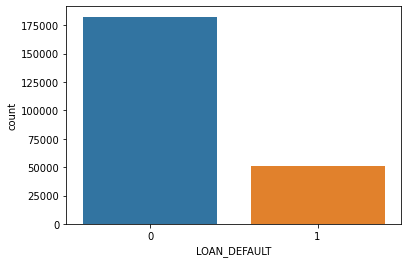

In [149]:
# Target Variable
print(loan_df['LOAN_DEFAULT'].value_counts())
print("\n")
print(loan_df['LOAN_DEFAULT'].value_counts(normalize = True))
print("\n")

# Visualizing Target Variable
sns.countplot(x="LOAN_DEFAULT", data=loan_df)
plt.show()

### Cleaning the data

In [150]:
# Finding Missing Values
loan_df.isnull().any()

DISBURSED_AMOUNT                       False
ASSET_COST                             False
LTV                                    False
BRANCH_ID                              False
SUPPLIER_ID                            False
MANUFACTURER_ID                        False
CURRENT_PINCODE_ID                     False
DATE_OF_BIRTH                          False
EMPLOYMENT_TYPE                         True
DISBURSAL_DATE                         False
STATE_ID                               False
EMPLOYEE_CODE_ID                       False
MOBILENO_AVL_FLAG                      False
AADHAR_FLAG                            False
PAN_FLAG                               False
VOTERID_FLAG                           False
DRIVING_FLAG                           False
PASSPORT_FLAG                          False
PERFORM_CNS_SCORE                      False
PERFORM_CNS_SCORE_DESCRIPTION          False
PRI_NO_OF_ACCTS                        False
PRI_ACTIVE_ACCTS                       False
PRI_OVERDU

Self employed    127635
Salaried          97858
Missing            7661
Name: EMPLOYMENT_TYPE, dtype: int64


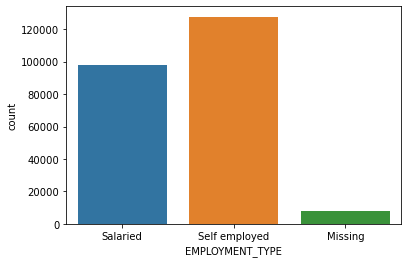

In [151]:
# Replacing Missing Values
loan_df = loan_df.fillna(value={'EMPLOYMENT_TYPE' : 'Missing'})
print(loan_df['EMPLOYMENT_TYPE'].value_counts())

# Plotting Employment Type
sns.countplot(x="EMPLOYMENT_TYPE", data=loan_df)
plt.show()

In [152]:
# Defining Functions
# Function for Calculating Months
def calc_months(str_list):  
    years = int(str_list[0])
    months = int(str_list[1])

    num_months = (years * 12) + months
    return num_months

# Function for Converting Strings to Months
def convert_str_to_months(col_name):
    new_col = col_name + '_MONTHS'
    loan_df[new_col] = loan_df[col_name].str.findall('\d+')
    loan_df[new_col] = loan_df[new_col].map(calc_months)

In [153]:
# Adding New Columns and Dropping Unwanted Columns

# AGE
loan_df['DATE_OF_BIRTH'] = pd.to_datetime(loan_df['DATE_OF_BIRTH'])
loan_df['DISBURSAL_DATE'] = pd.to_datetime(loan_df['DISBURSAL_DATE'])
loan_df['AGE'] = loan_df['DISBURSAL_DATE'] - loan_df['DATE_OF_BIRTH']
loan_df['AGE'] = loan_df['AGE'] // np.timedelta64(1, 'Y')

# DISBURSAL_MONTH
loan_df['DISBURSAL_MONTH'] = loan_df['DISBURSAL_DATE'].dt.month

# AVERAGE_ACCT_AGE_MONTHS
convert_str_to_months('AVERAGE_ACCT_AGE')

# CREDIT_HISTORY_LENGTH_MONTHS
convert_str_to_months('CREDIT_HISTORY_LENGTH')

# Dropping Columns
loan_df = loan_df.drop(['DISBURSAL_DATE', 'DATE_OF_BIRTH', 'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH'], axis=1)


In [154]:
# Adding and Dropping Columns
loan_df['DISBURSAL_DIFFERENCE'] = loan_df['ASSET_COST'] - loan_df['DISBURSED_AMOUNT']
loan_df['TOTAL_ACCTS'] = loan_df['PRI_NO_OF_ACCTS'] + loan_df['SEC_NO_OF_ACCTS']
loan_df['TOTAL_ACTIVE_ACCTS'] = loan_df['PRI_ACTIVE_ACCTS'] + loan_df['SEC_ACTIVE_ACCTS']
loan_df['TOTAL_OVERDUE_ACCTS'] = loan_df['PRI_OVERDUE_ACCTS'] + loan_df['SEC_OVERDUE_ACCTS']
loan_df['TOTAL_CURRENT_BALANCE'] = loan_df['PRI_CURRENT_BALANCE'] + loan_df['SEC_CURRENT_BALANCE']
loan_df['TOTAL_SANCTIONED_AMOUNT'] = loan_df['PRI_SANCTIONED_AMOUNT'] + loan_df['SEC_SANCTIONED_AMOUNT'] 
loan_df['TOTAL_DISBURSED_AMOUNT'] = loan_df['PRI_DISBURSED_AMOUNT'] + loan_df['SEC_DISBURSED_AMOUNT']
loan_df['TOTAL_INSTAL_AMT'] = loan_df['PRIMARY_INSTAL_AMT'] + loan_df['SEC_INSTAL_AMT']

loan_df['OVERDUE_PCT'] = loan_df['TOTAL_OVERDUE_ACCTS'] / loan_df['TOTAL_ACCTS']

# Replace Missing Value
loan_df['OVERDUE_PCT'] = loan_df['OVERDUE_PCT'].fillna(0)

drop_cols = ['PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT', 'SEC_INSTAL_AMT']
loan_df = loan_df.drop(drop_cols, axis=1)

In [155]:
# Info
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233154 entries, 420825 to 630213
Data columns (total 35 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   DISBURSED_AMOUNT                     233154 non-null  int64  
 1   ASSET_COST                           233154 non-null  int64  
 2   LTV                                  233154 non-null  float64
 3   BRANCH_ID                            233154 non-null  int64  
 4   SUPPLIER_ID                          233154 non-null  int64  
 5   MANUFACTURER_ID                      233154 non-null  int64  
 6   CURRENT_PINCODE_ID                   233154 non-null  int64  
 7   EMPLOYMENT_TYPE                      233154 non-null  object 
 8   STATE_ID                             233154 non-null  int64  
 9   EMPLOYEE_CODE_ID                     233154 non-null  int64  
 10  MOBILENO_AVL_FLAG                    233154 non-null  int64  
 11  AADHAR_F

### Exploratory Data Analysis

In [156]:
# Unique Values
loan_df.nunique()

DISBURSED_AMOUNT                       24565
ASSET_COST                             46252
LTV                                     6579
BRANCH_ID                                 82
SUPPLIER_ID                             2953
MANUFACTURER_ID                           11
CURRENT_PINCODE_ID                      6698
EMPLOYMENT_TYPE                            3
STATE_ID                                  22
EMPLOYEE_CODE_ID                        3270
MOBILENO_AVL_FLAG                          1
AADHAR_FLAG                                2
PAN_FLAG                                   2
VOTERID_FLAG                               2
DRIVING_FLAG                               2
PASSPORT_FLAG                              2
PERFORM_CNS_SCORE                        573
PERFORM_CNS_SCORE_DESCRIPTION             20
NEW_ACCTS_IN_LAST_SIX_MONTHS              26
DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS       14
NO_OF_INQUIRIES                           25
LOAN_DEFAULT                               2
AGE       

In [157]:
# Dropping MOBILENO_AVL_FLAG
loan_df = loan_df.drop(['MOBILENO_AVL_FLAG'], axis = 1)

In [158]:
# Exploring IDs
loan_df[['SUPPLIER_ID', 'CURRENT_PINCODE_ID', 'EMPLOYEE_CODE_ID', 'BRANCH_ID', 'STATE_ID', 'MANUFACTURER_ID']].sample(10)

,SUPPLIER_ID,CURRENT_PINCODE_ID,EMPLOYEE_CODE_ID,BRANCH_ID,STATE_ID,MANUFACTURER_ID
UNIQUEID,,,,,,
625081,20470,3339,745,138,9,86
549464,15663,3342,1139,5,9,86
458688,23437,6628,1335,36,13,51
619640,18129,1446,622,67,6,45
450511,23284,603,2056,160,15,45
433207,23000,1520,265,250,6,86
598444,24649,5950,2130,11,3,51
459285,21247,6894,2500,251,13,45
572053,22031,1738,1830,2,4,86


In [159]:
# Dropping unwanted IDs
loan_df = loan_df.drop(['SUPPLIER_ID', 'CURRENT_PINCODE_ID', 'EMPLOYEE_CODE_ID', 'BRANCH_ID'], axis=1)

In [160]:
# Function for Exploring Categorical Variables
def explore_categorical(col_name):   
    print("{0} Summary".format(col_name))
    print("\n")

    print("{0} Counts".format(col_name))
    print(loan_df[col_name].value_counts())
    print("\n")

    print("{0} Ratio".format(col_name))
    print(loan_df[col_name].value_counts(normalize=True))
    print("\n")

    print("{0} Default Counts".format(col_name))
    print(loan_df.groupby(col_name)['LOAN_DEFAULT'].value_counts().unstack(level=-1))
    print("\n")

    print("{0} Default Ratio".format(col_name))
    print(loan_df.groupby(col_name)['LOAN_DEFAULT'].value_counts(normalize=True).unstack(level=-1))
    print("\n")

    sns.catplot(data=loan_df,kind='count',x=col_name,hue='LOAN_DEFAULT')
    plt.show()

MANUFACTURER_ID Summary


MANUFACTURER_ID Counts
86     109534
45      56626
51      27204
48      16710
49      10220
120      9658
67       2405
145       778
153        12
152         6
156         1
Name: MANUFACTURER_ID, dtype: int64


MANUFACTURER_ID Ratio
86     0.469792
45     0.242870
51     0.116678
48     0.071669
49     0.043834
120    0.041423
67     0.010315
145    0.003337
153    0.000051
152    0.000026
156    0.000004
Name: MANUFACTURER_ID, dtype: float64


MANUFACTURER_ID Default Counts
LOAN_DEFAULT           0        1
MANUFACTURER_ID                  
45               43687.0  12939.0
48               12156.0   4554.0
49                7984.0   2236.0
51               21547.0   5657.0
67                1882.0    523.0
86               87124.0  22410.0
120               7526.0   2132.0
145                622.0    156.0
152                  6.0      NaN
153                  8.0      4.0
156                  1.0      NaN


MANUFACTURER_ID Default Ratio
LOAN_DEFAULT    

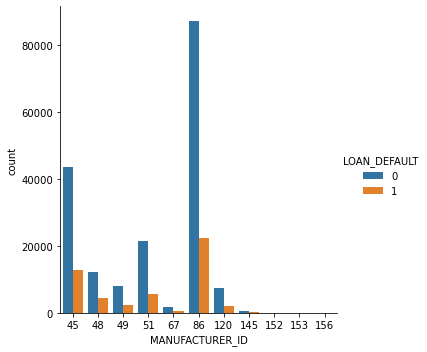

In [161]:
explore_categorical("MANUFACTURER_ID")

In [162]:
# Function for Exploring Continuous Variables
def explore_continuous(col_name):
    #print statistical summary
    print("{0} Summary".format(col_name))
    print("\n")
    print(loan_df[col_name].describe())
    print("\n")

    #Look at boxplot
    sns.boxplot(x=col_name, data=loan_df)
    plt.show()

    #Look at the distribution
    sns.distplot(loan_df[col_name], hist=False)
    plt.show()

    #Now lets look deeper by grouping with the target variable 
    print("{0} Grouped Summary".format(col_name))
    print("\n")
    print(loan_df.groupby('LOAN_DEFAULT')[col_name].describe())

    #look at grouped boxplot 
    sns.boxplot(x=col_name, y='LOAN_DEFAULT', data=loan_df, orient="h")
    plt.show()

DISBURSED_AMOUNT Summary


count    233154.000000
mean      54356.993528
std       12971.314171
min       13320.000000
25%       47145.000000
50%       53803.000000
75%       60413.000000
max      990572.000000
Name: DISBURSED_AMOUNT, dtype: float64




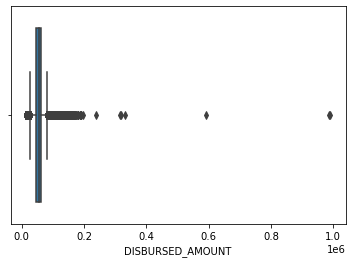

/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


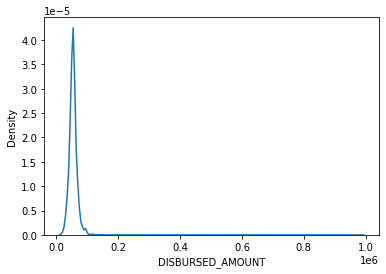

DISBURSED_AMOUNT Grouped Summary


                 count          mean           std      min      25%      50%  \
LOAN_DEFAULT                                                                    
0             182543.0  53826.471111  13140.699007  13320.0  46369.0  53303.0   
1              50611.0  56270.473869  12150.255527  13369.0  49303.0  55459.0   

                  75%       max  
LOAN_DEFAULT                     
0             59947.0  990572.0  
1             61947.0  191392.0  


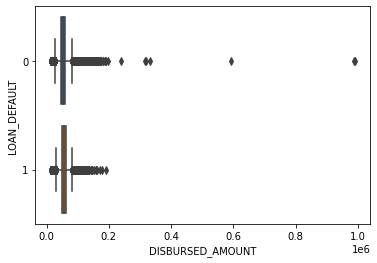

In [163]:
explore_continuous('DISBURSED_AMOUNT')

### Binning

In [168]:
disbursed_buckets = [13000, 30000, 45000, 60000, 75000, 150000, 1000000]
disbursed_labels = ['13k - 30k', '30k - 45k', '45k - 60k', '60k - 75k', '75k - 150k', '150k - 1m']
loan_df['DISBURSED_CAT'] = pd.cut(loan_df['DISBURSED_AMOUNT'], disbursed_buckets, labels=disbursed_labels)

### Logistic Regression

In [169]:
category_cols = ['MANUFACTURER_ID', 'STATE_ID', 'DISBURSAL_MONTH', 'DISBURSED_CAT', 'PERFORM_CNS_SCORE_DESCRIPTION', 'EMPLOYMENT_TYPE']
loan_df[category_cols] = loan_df[category_cols].astype('category')

In [170]:
small_cols = ['STATE_ID', 'LTV', 'DISBURSED_CAT', 'PERFORM_CNS_SCORE', 'DISBURSAL_MONTH', 'LOAN_DEFAULT']
loan_df_sml = loan_df[small_cols]

loan_data_dumm = pd.get_dummies(loan_df_sml, prefix_sep='_', drop_first=True)

x = loan_data_dumm.drop(['LOAN_DEFAULT'], axis=1)
y = loan_data_dumm['LOAN_DEFAULT']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression(max_iter=200)
logistic_model.fit(x_train, y_train)

/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

### Model Evaluation

In [171]:
# Function for ROC Curve
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [172]:
# Function for Model Evaluation
def eval_model(model, x_test, y_test):
    preds = model.predict(x_test)
    probs = model.predict_proba(x_test)

    accuracy = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    plot_confusion_matrix(model, x_test, y_test)
    plt.show()

    print("\n")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    #Show ROC Curve 
    fpr, tpr, threshold = roc_curve(y_test, probs[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("AUC: ", roc_auc)

    plot_roc_curve(fpr, tpr, roc_auc)

    results_df = pd.DataFrame()
    results_df['true_class'] = y_test
    results_df['predicted_class'] = list(preds)
    results_df['default_prob'] = probs[:, 1]

    #plot the distribution of probabilities for the estimated classes 
    sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label="No Default", hist=False)
    sns.distplot(results_df[results_df['true_class'] == 1]['default_prob'], label="Default", hist=False)
    plt.show()
    
    #see the true class versus predicted class as a percentage
    print(results_df.groupby('true_class')['predicted_class'].value_counts(normalize=True))

/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


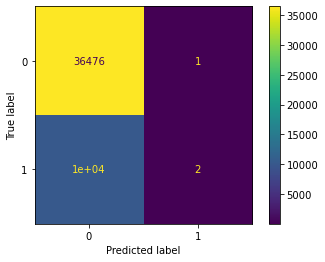



Accuracy:  0.782269305826596
Precision:  0.6666666666666666
Recall:  0.00019696671262556627
F1:  0.00039381707197006985
AUC:  0.6066978731229069


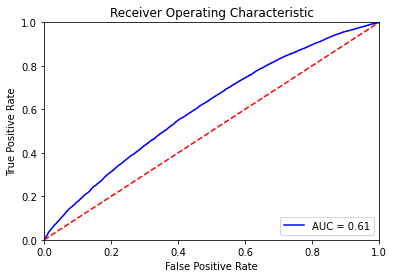

/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


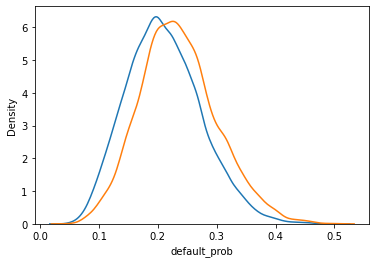

true_class  predicted_class
0           0                  0.999973
            1                  0.000027
1           0                  0.999803
            1                  0.000197
Name: predicted_class, dtype: float64


In [173]:
eval_model(logistic_model, x_test, y_test)

### Random Forest Classifier

In [174]:
# Function for Splitting Data
def encode_and_split(loan_df):
    loan_data_dumm = pd.get_dummies(loan_df, prefix_sep='_', drop_first=True)

    x = loan_data_dumm.drop(['LOAN_DEFAULT'], axis=1)
    y = loan_data_dumm['LOAN_DEFAULT']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    return x_train, x_test, y_train, y_test

In [98]:
x_train, x_test, y_train, y_test = encode_and_split(loan_df)

/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


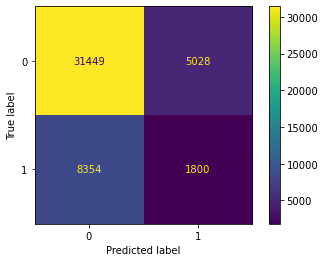



Accuracy:  0.7130235251227725
Precision:  0.26362038664323373
Recall:  0.17727004136300964
F1:  0.21198916499823342
AUC:  0.5546148973543268


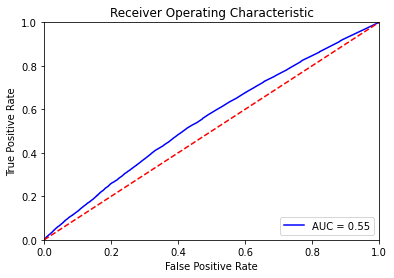

/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


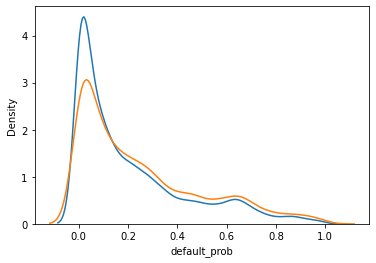

true_class  predicted_class
0           0                  0.86216
            1                  0.13784
1           0                  0.82273
            1                  0.17727
Name: predicted_class, dtype: float64


In [175]:
rfc_model = RandomForestClassifier()
rfc_model.fit(x_train, y_train)

eval_model(rfc_model, x_test, y_test)

/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


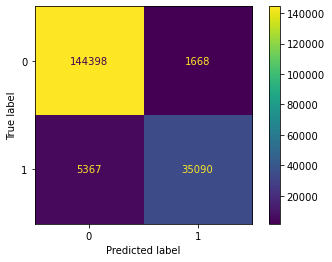



Accuracy:  0.9622834717434311
Precision:  0.954622123075249
Recall:  0.8673406332649479
F1:  0.9088907595674417
AUC:  0.9924891317443082


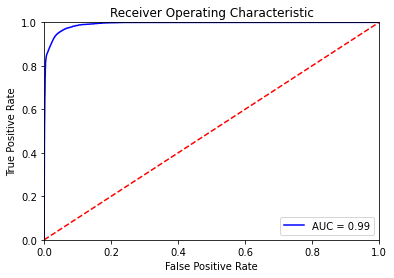

/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


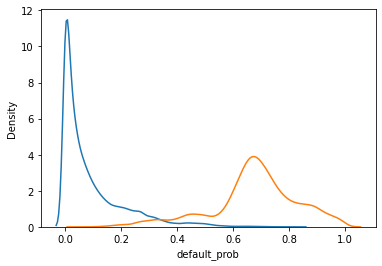

true_class  predicted_class
0           0                  0.988581
            1                  0.011419
1           1                  0.867341
            0                  0.132659
Name: predicted_class, dtype: float64


In [176]:
# Checking for Overfitting
eval_model(rfc_model, x_train, y_train)

/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


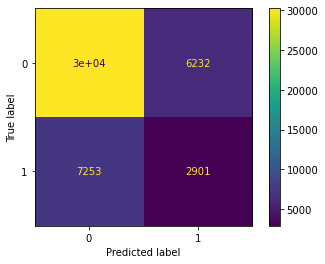



Accuracy:  0.7108146940876241
Precision:  0.31763932990255117
Recall:  0.2857002166633839
F1:  0.30082438948514545
AUC:  0.6155127531343139


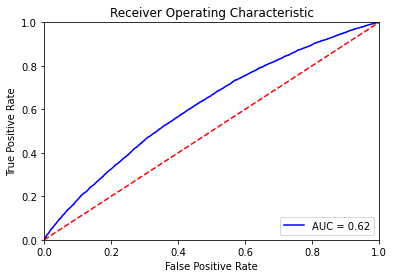

/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


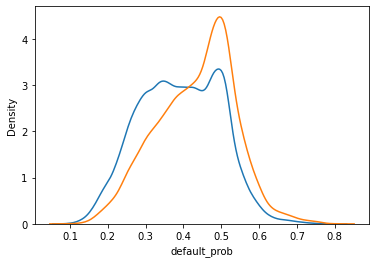

true_class  predicted_class
0           0                  0.829153
            1                  0.170847
1           0                  0.714300
            1                  0.285700
Name: predicted_class, dtype: float64


In [177]:
# Adjusting the Overfitting Model
weights = {0:0.27, 1:0.73}

rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 15, class_weight=weights)

rfc_model.fit(x_train, y_train)
eval_model(rfc_model, x_test, y_test)

/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


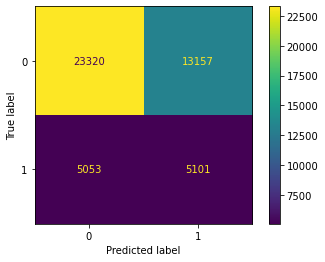



Accuracy:  0.6094872509703845
Precision:  0.2793843794501041
Recall:  0.5023636005515068
F1:  0.3590736308601999
AUC:  0.602544996272525


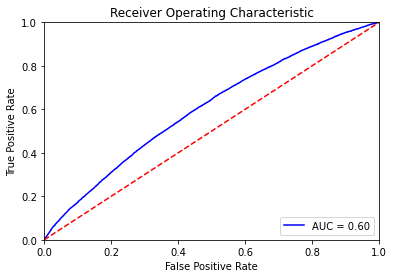

/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/rohith/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


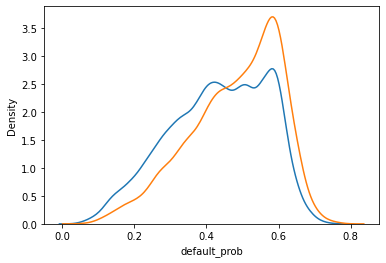

true_class  predicted_class
0           0                  0.639307
            1                  0.360693
1           1                  0.502364
            0                  0.497636
Name: predicted_class, dtype: float64


In [178]:
# SMOTE
smote = SMOTE()
x_train_synth, y_train_synth = smote.fit_resample(x_train, y_train)

rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 15)

rfc_model.fit(x_train_synth, y_train_synth)
eval_model(rfc_model, x_test, y_test)